# GAN(생성적 적대 신경망)
- 비지도학습에 사용되는 머신러닝 프레임워크
- 일반 알고리즘과 달리 이전에 없던 새로운 데이터를 생성함
---
- **생성자(Genrator)** 는 최대한 진짜 같은 데이터를 만들기 위한 학습을 진행하고
- **판별자(Discriminator)** 는 진짜와 가짜를 판별하기 위한 학습을 진행함
---
__학습과정__
1. 분류모델 학습
    - 진짜 데이터를 진짜로 분류하도록 학습
    - 생성모델이 생성한 데이터를 가짜로 분류하도록 학습
    - 특징맵의 크기를 줄여나가는 구조로, 전통적인 인공신경망의 구조를 따름
2. 생성모델 학습
    - 학습된 분류모델을 속이는 방향으로 생성모델 학습
    - 생성모델은 노이즈를 입력으로 받아 다수의 층을 통과하며, 특징 맵을 확장하는 구조로 이루어져 있음
    - 마지막 층을 통과해서 나오는 특징 맵은 이미지의 크기와 같음
    
참고 : https://baechu-story.tistory.com/12

# GAN으로 새로운 패션아이템 생성

##### 라이브러리 불러오기

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image

##### CUDA 코어(GPU)의 사용여부 검사 후 디바이스에 할당

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('Using Device :', DEVICE)

Using Device : cuda


##### 하이퍼파라미터 

- epochs : 학습의 반복 횟수
- batch_size : 한 번에 학습하는 데이터 크기

In [4]:
epochs = 500
batch_size = 100

#####  데이터 불러오기

In [7]:
# Fashion MNIST
trainset = datasets.FashionMNIST(
    './data', train = True, download = True,
    transform = transforms.Compose([
        transforms.ToTensor(), # 데이터를 텐서로 변환
        transforms.Normalize((0.5),(0.5)) # 평균 : 0.5 , 표준편차 0.5
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = batch_size,
    shuffle = True
)

0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...
Done!


##### 생성자 (Generator) : 이미지를 생성하는 생성자
- 입력 : 64개의 노드(64차원)
- 출력 : 784개의 노드(784차원) --> 28 x 28 크기의 이미지를 생성해야하기 때문
---
- 생성자는 64차원의 랜덤한 Tensor를 입력받아 이에 행렬곱(Linear)과 활성화  함수(ReLU, Tanh) 연산을 실행함
- 생성자의 결과값은 784차원, 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서임

In [14]:
# 생성자
G = nn.Sequential(
    nn.Linear(64,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Tanh())

##### 판별자 (Discriminator) : 생성한 이미지가 참인지 거짓인지 구분하는 판별자
- 입력 : 784개의 노드(784차원)
- 출력 : 1 --> 입력된 이미지 데이터가 참인지 거짓인지를 구분하는 값인 bool값을 출력하기 때문
---
- 판별자는 784차원의 Tensor를 입력받음
- 판별자도 생성자와 마찬가지로 행렬곱, 활성화 함수를 실행함
- 다만 판별자의 결과값은 입력받은 Tesor의 값이 진짜인지 구분하는 예측 값임

In [13]:
# 판별자
D = nn.Sequential(
    nn.Linear(784,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
    nn.Sigmoid())

##### 모델의 가중치를 CUDA (GPU) 로 전달

In [15]:
D = D.to(DEVICE)
G = G.to(DEVICE)

##### 최적화 알고리즘 
- BCE Loss : 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수 : 
$ BCELoss(\hat{y} = 예측,y = 실제) = -(y \times log\hat{y} + (1-y) \times log(1-\hat{y}))$
- Adam : 생성자와 판별자를 최적화할 모듈

In [67]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002)

##### GAN을 학습시키는 loop 생성

In [69]:
# 2시간 걸림 GPU
for epoch in range(epochs):
    for i,(images, _) in enumerate(train_loader):
        # images는 784크기의 한 장의 이미지가 아닌 batch_size 만큼의 이미지가 저장되어 있음
        # 따라서 batch_size 만큼의 이미지 중 하나씩 사용하기 위하여 Reshape를 수행함
        # 그리고 GPU 사용을 위해 GPU DEVICE에 전달
        images = images.reshape(batch_size, -1).to(DEVICE)
    
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(batch_size, 1).to(DEVICE) # 참인 데이터는 모두 1로 생성
        fake_labels = torch.zeros(batch_size,1).to(DEVICE) # 거짓인 데이터는 모두 0으로 생성
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        # 참인 데이터는 모두 1이기 때문에
        # output이 0이면 오차는 1
        # output이 1이면 오차는 0
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels) # criterion : Binary Cross Entropy
        real_score = outputs
        
        # 무작위 Tensor로 가짜 이미지 생성
        z = torch.randn(batch_size, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        # 거짓인 데이터는 모두 0이기 때문에
        # output이 0이면 오차는 0
        # output이 1이면 오차는 1
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 계산한 진짜와 가짜 이미지 오차 결과를 합산하여 판별자의 최종 오차를 계산
        d_loss = d_loss_real + d_loss_fake
        
        
        # 한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.
        # 이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면
        # 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.
        # 따라서 루프가 한번 돌고나서 역전파를 하기전에 반드시 zero_grad()로 .grad 값들을 0으로 초기화시킨 후 학습을 진행해야 한다.
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        # 자동미분(backward)을 이용하여 판별자 모델의 학습을 수행
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산함
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        
        # 역전파 전 grad 값 초기화
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        # 자동미분(backward)을 이용하여 생성자 모델의 학습을 수행
        g_loss.backward()
        g_optimizer.step()

    # 학습 진행률 알아보기
    print(f'''Epoch [{epoch}] / {epochs}], d_loss : {d_loss.item():.4f}, g_loss : {g_loss.item():.4f},
          D(x) : {real_score.mean().item():.2f}, D(G(z)) : {fake_score.mean().item():.2f}''')

Epoch [0] / 500], d_loss : 0.0412, g_loss : 4.4198,
          D(x) : 0.98, D(G(z)) : 0.02
Epoch [1] / 500], d_loss : 0.0356, g_loss : 6.0258,
          D(x) : 0.98, D(G(z)) : 0.01
Epoch [2] / 500], d_loss : 0.0189, g_loss : 8.1129,
          D(x) : 0.99, D(G(z)) : 0.01
Epoch [3] / 500], d_loss : 0.0462, g_loss : 7.3602,
          D(x) : 0.99, D(G(z)) : 0.02
Epoch [4] / 500], d_loss : 0.0282, g_loss : 6.6995,
          D(x) : 1.00, D(G(z)) : 0.02
Epoch [5] / 500], d_loss : 0.0990, g_loss : 6.4923,
          D(x) : 0.96, D(G(z)) : 0.02
Epoch [6] / 500], d_loss : 0.0806, g_loss : 5.5588,
          D(x) : 0.98, D(G(z)) : 0.03
Epoch [7] / 500], d_loss : 0.3953, g_loss : 3.5724,
          D(x) : 0.90, D(G(z)) : 0.08
Epoch [8] / 500], d_loss : 0.1351, g_loss : 5.5490,
          D(x) : 0.96, D(G(z)) : 0.05
Epoch [9] / 500], d_loss : 0.2581, g_loss : 5.3713,
          D(x) : 0.93, D(G(z)) : 0.08
Epoch [10] / 500], d_loss : 0.3623, g_loss : 4.4316,
          D(x) : 0.90, D(G(z)) : 0.03
Epoch [11

Epoch [91] / 500], d_loss : 0.7757, g_loss : 1.9505,
          D(x) : 0.76, D(G(z)) : 0.25
Epoch [92] / 500], d_loss : 0.7706, g_loss : 1.7107,
          D(x) : 0.75, D(G(z)) : 0.28
Epoch [93] / 500], d_loss : 0.7314, g_loss : 1.9391,
          D(x) : 0.74, D(G(z)) : 0.22
Epoch [94] / 500], d_loss : 0.8418, g_loss : 1.6710,
          D(x) : 0.75, D(G(z)) : 0.30
Epoch [95] / 500], d_loss : 0.7654, g_loss : 1.8098,
          D(x) : 0.72, D(G(z)) : 0.25
Epoch [96] / 500], d_loss : 0.9864, g_loss : 2.0952,
          D(x) : 0.68, D(G(z)) : 0.26
Epoch [97] / 500], d_loss : 1.0691, g_loss : 1.4947,
          D(x) : 0.78, D(G(z)) : 0.44
Epoch [98] / 500], d_loss : 0.8543, g_loss : 2.1474,
          D(x) : 0.78, D(G(z)) : 0.31
Epoch [99] / 500], d_loss : 0.8094, g_loss : 2.3537,
          D(x) : 0.74, D(G(z)) : 0.25
Epoch [100] / 500], d_loss : 0.8966, g_loss : 1.6020,
          D(x) : 0.81, D(G(z)) : 0.37
Epoch [101] / 500], d_loss : 0.6712, g_loss : 1.9717,
          D(x) : 0.73, D(G(z)) : 0.

Epoch [181] / 500], d_loss : 0.8031, g_loss : 1.5968,
          D(x) : 0.73, D(G(z)) : 0.31
Epoch [182] / 500], d_loss : 1.0816, g_loss : 1.5188,
          D(x) : 0.65, D(G(z)) : 0.34
Epoch [183] / 500], d_loss : 0.9541, g_loss : 1.4107,
          D(x) : 0.66, D(G(z)) : 0.30
Epoch [184] / 500], d_loss : 1.1837, g_loss : 1.2145,
          D(x) : 0.63, D(G(z)) : 0.39
Epoch [185] / 500], d_loss : 1.0019, g_loss : 1.4469,
          D(x) : 0.68, D(G(z)) : 0.35
Epoch [186] / 500], d_loss : 1.0187, g_loss : 1.3169,
          D(x) : 0.66, D(G(z)) : 0.36
Epoch [187] / 500], d_loss : 1.1002, g_loss : 1.2991,
          D(x) : 0.58, D(G(z)) : 0.31
Epoch [188] / 500], d_loss : 1.0016, g_loss : 1.4828,
          D(x) : 0.66, D(G(z)) : 0.32
Epoch [189] / 500], d_loss : 1.0343, g_loss : 1.4803,
          D(x) : 0.62, D(G(z)) : 0.30
Epoch [190] / 500], d_loss : 0.8893, g_loss : 1.5626,
          D(x) : 0.73, D(G(z)) : 0.34
Epoch [191] / 500], d_loss : 1.0699, g_loss : 1.3599,
          D(x) : 0.63, D(G

Epoch [271] / 500], d_loss : 1.2952, g_loss : 1.2292,
          D(x) : 0.61, D(G(z)) : 0.41
Epoch [272] / 500], d_loss : 1.3103, g_loss : 1.1351,
          D(x) : 0.64, D(G(z)) : 0.42
Epoch [273] / 500], d_loss : 1.2857, g_loss : 1.2649,
          D(x) : 0.57, D(G(z)) : 0.35
Epoch [274] / 500], d_loss : 1.4087, g_loss : 1.0601,
          D(x) : 0.55, D(G(z)) : 0.40
Epoch [275] / 500], d_loss : 1.5197, g_loss : 1.0818,
          D(x) : 0.56, D(G(z)) : 0.44
Epoch [276] / 500], d_loss : 1.0640, g_loss : 1.5141,
          D(x) : 0.64, D(G(z)) : 0.33
Epoch [277] / 500], d_loss : 1.0260, g_loss : 1.1681,
          D(x) : 0.68, D(G(z)) : 0.38
Epoch [278] / 500], d_loss : 1.2123, g_loss : 1.5988,
          D(x) : 0.60, D(G(z)) : 0.32
Epoch [279] / 500], d_loss : 1.0183, g_loss : 1.2333,
          D(x) : 0.70, D(G(z)) : 0.39
Epoch [280] / 500], d_loss : 1.0010, g_loss : 1.3638,
          D(x) : 0.69, D(G(z)) : 0.37
Epoch [281] / 500], d_loss : 1.1386, g_loss : 1.3106,
          D(x) : 0.65, D(G

Epoch [361] / 500], d_loss : 0.9821, g_loss : 1.4869,
          D(x) : 0.66, D(G(z)) : 0.30
Epoch [362] / 500], d_loss : 1.0210, g_loss : 1.4461,
          D(x) : 0.65, D(G(z)) : 0.33
Epoch [363] / 500], d_loss : 1.0309, g_loss : 1.3420,
          D(x) : 0.69, D(G(z)) : 0.36
Epoch [364] / 500], d_loss : 1.1703, g_loss : 1.2088,
          D(x) : 0.64, D(G(z)) : 0.36
Epoch [365] / 500], d_loss : 1.0042, g_loss : 1.4508,
          D(x) : 0.65, D(G(z)) : 0.32
Epoch [366] / 500], d_loss : 1.0304, g_loss : 1.4713,
          D(x) : 0.63, D(G(z)) : 0.31
Epoch [367] / 500], d_loss : 1.1959, g_loss : 1.1889,
          D(x) : 0.65, D(G(z)) : 0.39
Epoch [368] / 500], d_loss : 1.0239, g_loss : 1.4922,
          D(x) : 0.64, D(G(z)) : 0.32
Epoch [369] / 500], d_loss : 0.8605, g_loss : 1.6836,
          D(x) : 0.66, D(G(z)) : 0.26
Epoch [370] / 500], d_loss : 0.9679, g_loss : 1.3681,
          D(x) : 0.70, D(G(z)) : 0.33
Epoch [371] / 500], d_loss : 1.0066, g_loss : 1.3254,
          D(x) : 0.66, D(G

Epoch [451] / 500], d_loss : 0.9587, g_loss : 1.3966,
          D(x) : 0.68, D(G(z)) : 0.34
Epoch [452] / 500], d_loss : 1.1158, g_loss : 1.2349,
          D(x) : 0.67, D(G(z)) : 0.39
Epoch [453] / 500], d_loss : 0.9844, g_loss : 1.3381,
          D(x) : 0.68, D(G(z)) : 0.35
Epoch [454] / 500], d_loss : 1.0046, g_loss : 1.5927,
          D(x) : 0.65, D(G(z)) : 0.29
Epoch [455] / 500], d_loss : 0.9284, g_loss : 1.5379,
          D(x) : 0.66, D(G(z)) : 0.30
Epoch [456] / 500], d_loss : 1.1561, g_loss : 1.3213,
          D(x) : 0.61, D(G(z)) : 0.32
Epoch [457] / 500], d_loss : 1.0587, g_loss : 1.4289,
          D(x) : 0.63, D(G(z)) : 0.32
Epoch [458] / 500], d_loss : 1.2032, g_loss : 0.9303,
          D(x) : 0.69, D(G(z)) : 0.47
Epoch [459] / 500], d_loss : 0.8428, g_loss : 1.4856,
          D(x) : 0.73, D(G(z)) : 0.31
Epoch [460] / 500], d_loss : 1.2205, g_loss : 1.2865,
          D(x) : 0.64, D(G(z)) : 0.37
Epoch [461] / 500], d_loss : 0.9890, g_loss : 1.4942,
          D(x) : 0.64, D(G

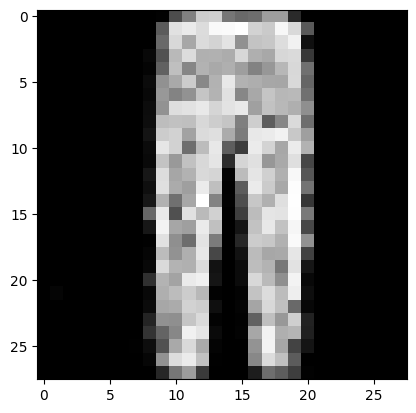

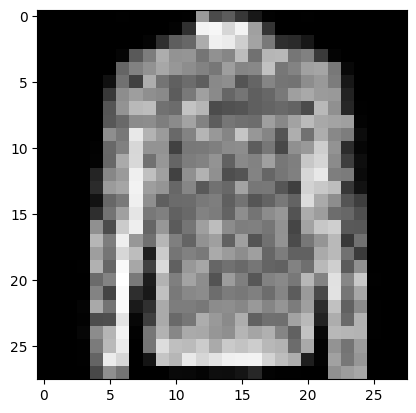

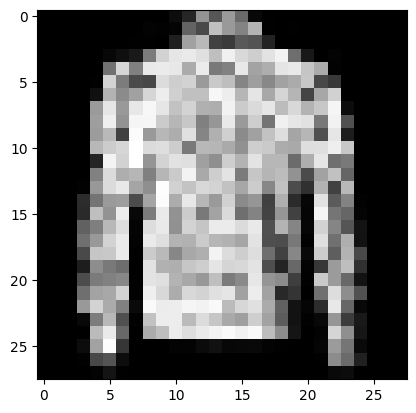

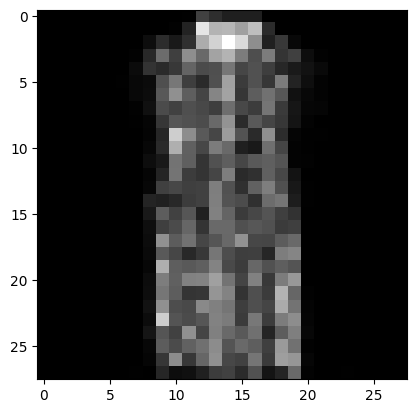

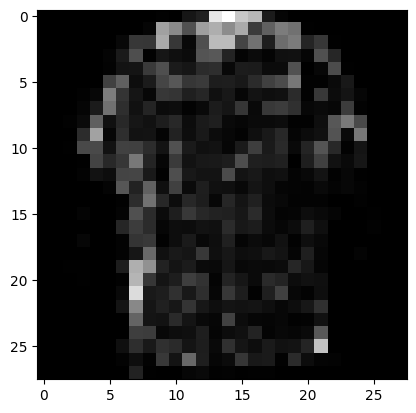

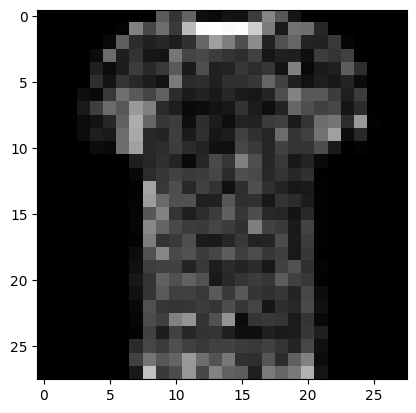

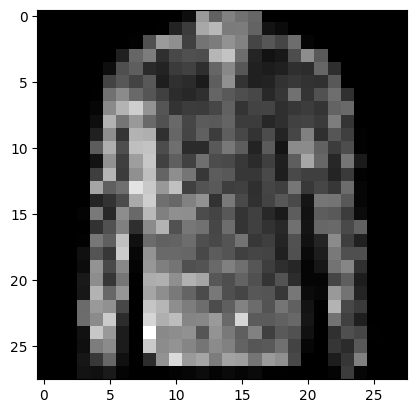

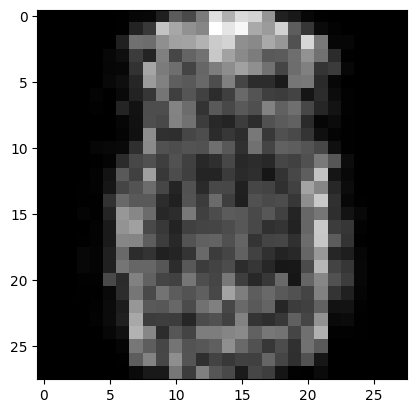

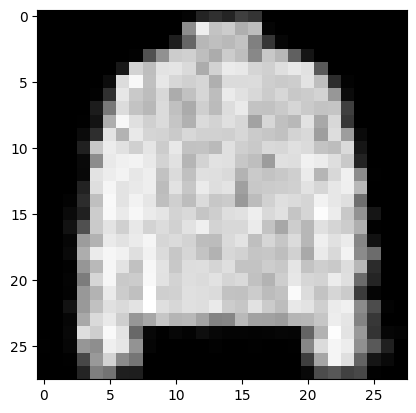

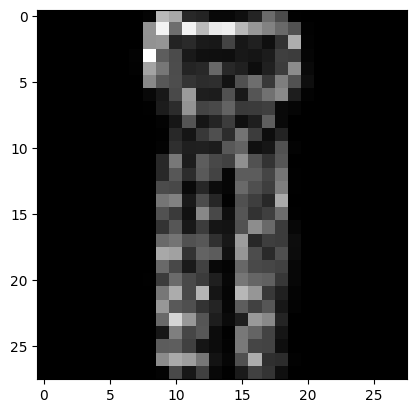

In [77]:
# 결과 확인하기
z = torch.randn(batch_size, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()